# Flood Adaptation: Minimal Model

This python script outlines a basic Agent-Based Model (ABM) developed using the Mesa framework, designed as a simplified representation of household adaptation to flood events in a social network context. The model serves as a template for understanding the fundamental mechanics of flood adapdtation with a given social network.

This directory is structured as follows:
 - A Mesa Agent class `Households` is defined in `agents.py`
 - A Mesa Agent class `Government` is defined in `agents.py` (this agent currently does not perform any action)
 - A Mesa Model class `AdaptationModel` is defined in `model.py`
 - This notebook `demo.ipynb` provides a demonstration of the model and its visualization.

Each household agent in the model represents a household with attributes and behaviors that determine its response to flood events. The flood depth attribute assigned to each household is currently random for demonstration purposes. The decision by each household to adapt is also arbitrary. In a more comprehensive model, this could be replaced with more sophisticated decision-making algorithms.

The current implementation includes several simplifications and arbitrary choices, such as random flood depths and basic adaptation logic based on random thresholds. These aspects are designed for clarity and ease of understanding and should be replaced with realistic and sound choices.

You are encouraged to modify, expand, and customize the model. This might include integrating real-world data, implementing more complex decision-making processes for agents, or exploring different network topologies and their effects on social dynamics.

The visualisation provided is basic. Additional aspects can be added for visualization and more in-depth analysis.

_This notebook was tested on 2023-11-13 with Mesa version 2.1.4 on Python 3.12.0._

# Running the model and visualizing the model domain and social network over time

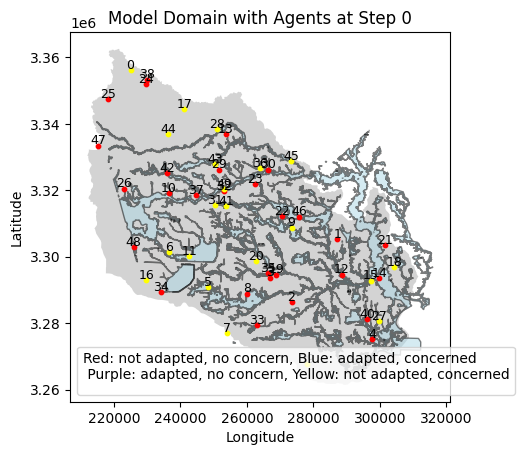

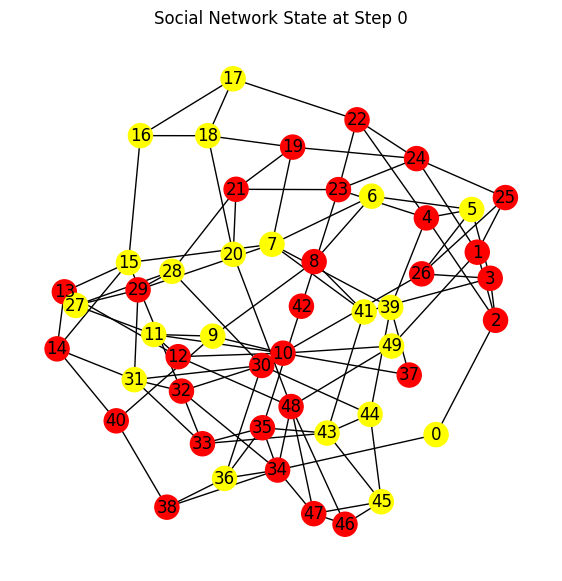

agent 18 and 20 are similar enough!
agent 30 and 26 are similar enough!
agent 16 and 15 are similar enough!
agent 26 and 30 are similar enough!
agent 34 and 47 are similar enough!
agent 20 and 18 are similar enough!
agent 13 and 14 are similar enough!
agent 14 and 13 are similar enough!
agent 39 and 7 are similar enough!
agent 7 and 39 are similar enough!
agent 1 and 2 are similar enough!
agent 2 and 1 are similar enough!
agent 47 and 34 are similar enough!
agent 15 and 16 are similar enough!
agent 16 and 15 are similar enough!
agent 30 and 26 are similar enough!
agent 34 and 47 are similar enough!
agent 2 and 1 are similar enough!
agent 7 and 39 are similar enough!
agent 26 and 30 are similar enough!
agent 15 and 16 are similar enough!
agent 13 and 14 are similar enough!
agent 39 and 7 are similar enough!
agent 1 and 2 are similar enough!
agent 20 and 18 are similar enough!
agent 18 and 20 are similar enough!
agent 14 and 13 are similar enough!
agent 47 and 34 are similar enough!
agen

In [1]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx

# Initialize the Adaptation Model with 50 household agents.
model = AdaptationModel(number_of_households=50, flood_map_choice="harvey", network="watts_strogatz") # flood_map_choice can be "harvey", "100yr", or "500yr"

# Calculate positions of nodes for the network plot.
# The spring_layout function positions nodes using a force-directed algorithm,
# which helps visualize the structure of the social network.
pos = nx.spring_layout(model.G)

# Define a function to plot agents on the network.
# This function takes a matplotlib axes object and the model as inputs.
def plot_network(ax, model):
    # Clear the current axes.
    ax.clear()
    # Determine the color of each node (agent) based on their adaptation status.
    colors = ['blue' if agent.is_adapted and agent.conviction > 0.5 else 'purple' if agent.is_adapted else 'yellow' if agent.conviction > 0.5 else 'red' for agent in model.schedule.agents]

    # Draw the network with node colors and labels.
    nx.draw(model.G, pos, node_color=colors, with_labels=True, ax=ax)
    # Set the title of the plot with the current step number.
    ax.set_title(f"Social Network State at Step {model.schedule.steps}", fontsize=12)

# Generate the initial plots at step 0.
# Plot the spatial distribution of agents. This is a function written in the model.py
model.plot_model_domain_with_agents()

# Plot the initial state of the social network.
fig, ax = plt.subplots(figsize=(7, 7))
plot_network(ax, model)
plt.show()

# Run the model for 20 steps and generate plots every 5 steps.
for step in range(20):
    model.step()

    # Every 5 steps, generate and display plots for both the spatial distribution and network.
    # Note the first step is step 0, so the plots will be generated at steps 4, 9, 14, and 19, which are the 5th, 10th, 15th, and 20th steps.
    # if (step + 1) % 5 == 0:
    #     # Plot for the spatial map showing agent locations and adaptation status.
    #     plt.figure(figsize=(10, 6))
    #     model.plot_model_domain_with_agents()
    # 
    #     # Plot for the social network showing connections and adaptation statuses.
    #     fig, ax = plt.subplots(figsize=(7, 7))
    #     plot_network(ax, model)
    #     plt.show()

In [2]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data

FloodDepthEstimated  FloodDamageEstimated  FloodDepthActual  \
Step AgentID                                                                
0    0                   0.000000              0.000000          0.000000   
     1                   1.936695              0.763708          0.000000   
     2                   0.000000              0.000000          0.000000   
     3                   0.000000              0.000000          0.000000   
     4                   0.000000              0.000000          0.000000   
...                           ...                   ...               ...   
19   45                  0.304989              0.440966          0.175680   
     46                  0.646233              0.572070          0.574364   
     47                  1.117287              0.667664          1.285580   
     48                  0.451378              0.509414          0.227300   
     49                  0.000000              0.000000          0.000000   

              FloodDamageActual  IsAdapted  Conviction  FriendsCount  \
Step AgentID                                                           
0    0                 0.000000      False    0.581495             0   
     1                 0.000000      False    0.610936             0   
     2                 0.000000      False    0.296826             0   
     3                 0.000000      False    0.771323             0   
     4                 0.000000      False    0.477136             0   
...                         ...        ...         ...           ...   
19   45                0.344655      False    0.810320             0   
     46                0.551486       True    0.003032             0   
     47                0.692161       True    0.253374             0   
     48                0.389632       True    0.384613             0   
     49                0.000000      False    0.826837             0   

                                                   location  
Step AgentID                                                 
0    0           POINT (275329.5344434136 3280589.57977403)  
     1         POINT (259044.4128383008 3341925.6225303467)  
     2         POINT (223991.2254712188 3307798.0997720724)  
     3         POINT (261697.93471579574 3303312.853936338)  
     4         POINT (302759.4942430645 3295776.4537046957)  
...                                                     ...  
19   45        POINT (259023.7141504208 3317018.2761305636)  
     46         POINT (278456.8529301465 3306983.657331841)  
     47        POINT (245509.3060558652 3318503.6089388323)  
     48        POINT (272606.32903674844 3270741.228583383)  
     49       POINT (233575.21270118613 3320091.7550458107)  

[1000 rows x 8 columns]

In [3]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

,total_adapted_households
0,0
1,3
2,11
3,13
4,18
5,23
6,24
7,28
8,33
9,34
